### GPU CHECKS AND IMPORTING DATA

All work was done in AWS, so google colab related code is removed as well as downloading of N-HPatches etc.

In [0]:
%cd keras_triplet_descriptor/

!pip install humanize
!pip install gputil
!pip install psutil
!pip install talos
!pip install sklearn
!pip install opencv-python
!pip install joblib
!pip install dill
!pip install tabulate
import psutil
import humanize
import os
import GPUtil as GPU

import sys
import json
import os
import glob
import time
import tensorflow as tf
import numpy as np
import cv2
import random
import talos
import pandas as pd
import matplotlib.pyplot as plt

import keras
from keras import backend as K
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, Input, Lambda, Reshape
from keras.layers import Conv2D, Conv3D, MaxPooling2D, BatchNormalization 
from keras.layers import Input, UpSampling2D, concatenate  
from keras.activations import sigmoid, relu, elu
from talos import live, Reporting
from talos.model.normalizers import lr_normalizer
from keras.losses import mean_squared_error, binary_crossentropy
from keras.optimizers import Adam, Nadam, SGD
from sklearn.preprocessing import MinMaxScaler
from keras.models import load_model
 
random.seed(1234)
np.random.seed(1234)
tf.set_random_seed(1234)   

#!wget -O hpatches_data.zip https://imperialcollegelondon.box.com/shared/static/ah40eq7cxpwq4a6l4f62efzdyt8rm3ha.zip
  
#!unzip -q ./hpatches_data.zip
#!rm ./hpatches_data.zip

hpatches_dir = './hpatches'
splits_path = './splits.json'

splits_json = json.load(open(splits_path, 'rb'))
split = splits_json['a']

train_fnames = split['train']
test_fnames = split['test']

seqs = glob.glob(hpatches_dir+'/*')
seqs = [os.path.abspath(p) for p in seqs]   
seqs_train = list(filter(lambda x: x.split('/')[-1] in train_fnames, seqs)) 
seqs_test = list(filter(lambda x: x.split('/')[-1] in split['test'], seqs))

from read_data import HPatches, DataGeneratorDesc, hpatches_sequence_folder, DenoiseHPatches, tps
from utils import generate_desc_csv, plot_denoise, plot_triplet

### DESCRIPTOR ARCHITECTURE EXPERIMENTS

Loading the denoising model from before and declaring a data generator for training and testing.

In [0]:
denoise_model = load_model('denoise.h5')

In [0]:
hPatches = HPatches(train_fnames=train_fnames, test_fnames=test_fnames, denoise_model=denoise_model, use_clean=False)
training_generator = DataGeneratorDesc(*hPatches.read_image_file(hpatches_dir, train=1), num_triplets=100000)
val_generator = DataGeneratorDesc(*hPatches.read_image_file(hpatches_dir, train=0), num_triplets=10000)

Using denoised patches
100%|██████████| 116/116 [00:34<00:00,  2.56it/s]
Denoising patches...
100%|██████████| 15589/15589 [02:25<00:00, 106.82it/s]


100%|██████████| 100000/100000 [00:01<00:00, 76999.53it/s]

Using denoised patches


100%|██████████| 116/116 [00:21<00:00,  5.51it/s]
Denoising patches...
100%|██████████| 9525/9525 [01:28<00:00, 107.99it/s]


100%|██████████| 10000/10000 [00:00<00:00, 61580.51it/s]


In this stage we are experimenting with an additional BN layer at the end of the network.

Evaluating the baseline descriptor model with the data from improved denoising stage.

In [0]:
def get_descriptor_model(shape):
  
  init_weights = keras.initializers.he_normal()
  
  descriptor_model = Sequential()
  
  descriptor_model.add(Conv2D(32, 3, padding='same', activation = 'relu', input_shape = shape , kernel_initializer=init_weights))
  descriptor_model.add(Activation('relu'))
  descriptor_model.add(BatchNormalization(axis = -1, gamma_initializer = 'ones', beta_initializer = 'zeros', trainable = True))

  descriptor_model.add(Conv2D(32, 3, padding='same', activation = 'relu', kernel_initializer=init_weights))
  descriptor_model.add(Activation('relu'))
  descriptor_model.add(BatchNormalization(axis = -1, gamma_initializer = 'ones', beta_initializer = 'zeros', trainable = True))

  descriptor_model.add(Conv2D(64, 3, padding='same', activation = 'relu', strides=2, kernel_initializer=init_weights))
  descriptor_model.add(Activation('relu'))
  descriptor_model.add(BatchNormalization(axis = -1, gamma_initializer = 'ones', beta_initializer = 'zeros', trainable = True))

  descriptor_model.add(Conv2D(64, 3, padding='same', activation = 'relu', kernel_initializer=init_weights))
  descriptor_model.add(Activation('relu'))
  descriptor_model.add(BatchNormalization(axis = -1, gamma_initializer = 'ones', beta_initializer = 'zeros', trainable = True))

  descriptor_model.add(Conv2D(128, 3, padding='same', activation = 'relu', strides=2, kernel_initializer=init_weights))
  descriptor_model.add(Activation('relu'))
  descriptor_model.add(BatchNormalization(axis = -1, gamma_initializer = 'ones', beta_initializer = 'zeros', trainable = True))

  descriptor_model.add(Conv2D(128, 3, padding='same', activation = 'relu', kernel_initializer=init_weights))
  descriptor_model.add(Activation('relu'))
  descriptor_model.add(BatchNormalization(axis = -1, gamma_initializer = 'ones', beta_initializer = 'zeros', trainable = True))
  descriptor_model.add(Dropout(0.3))
  descriptor_model.add(Conv2D(128, 8, padding='valid', kernel_initializer=init_weights))
                       
  descriptor_model.add(Reshape((128,)))

  
  return descriptor_model

def triplet_loss(x):

  output_dim = 128
  a, p, n = x
  _alpha = 1.0
  positive_distance = K.mean(K.square(a - p), axis = -1)
  negative_distance = K.mean(K.square(a - n), axis = -1)
  
  return K.expand_dims(K.maximum(0.0, positive_distance - negative_distance + _alpha), axis = 1)


shape = (32, 32, 1)
xa = Input(shape=shape, name='a')
xp = Input(shape=shape, name='p')
xn = Input(shape=shape, name='n')
descriptor_model = get_descriptor_model(shape)
ea = descriptor_model(xa)
ep = descriptor_model(xp)
en = descriptor_model(xn)

loss = Lambda(triplet_loss)([ea, ep, en])

descriptor_model_trip = Model(inputs=[xa, xp, xn], outputs=loss)

sgd = keras.optimizers.SGD(lr=0.1)
descriptor_model_trip.compile(loss='mean_absolute_error', optimizer=sgd)

In [0]:
descriptor_history_baseline_trip = descriptor_model_trip.fit_generator(generator=training_generator, epochs=25, verbose=1, validation_data=val_generator)

generate_desc_csv(descriptor_model, seqs_test, denoise_model = denoise_model, use_clean = False)

!python ./hpatches-benchmark/hpatches_eval.py --descr-name=custom --descr-dir=out/ --task=verification --delimiter=";"
!python ./hpatches-benchmark/hpatches_results.py --descr=custom --results-dir=./hpatches-benchmark/results/ --task=verification

!python ./hpatches-benchmark/hpatches_eval.py --descr-name=custom --descr-dir=out/ --task=matching --delimiter=";"
!python ./hpatches-benchmark/hpatches_results.py --descr=custom --results-dir=./hpatches-benchmark/results/ --task=matching

!python ./hpatches-benchmark/hpatches_eval.py --descr-name=custom --descr-dir=out/ --task=retrieval --delimiter=";"
!python ./hpatches-benchmark/hpatches_results.py --descr=custom --results-dir=./hpatches-benchmark/results/ --task=retrieval

Epoch 1/25
1999/2000 [============================>.] - ETA: 0s - loss: 0.2513

 60%|██████    | 60201/100000 [00:02<00:01, 29019.48it/s]

2000/2000 [==============================] - 51s 25ms/step - loss: 0.2514 - val_loss: 0.2987


 64%|██████▎   | 63621/100000 [00:02<00:01, 30398.50it/s]

Epoch 2/25


100%|██████████| 100000/100000 [00:03<00:00, 25259.89it/s]A


1999/2000 [============================>.] - ETA: 0s - loss: 0.1737

 24%|██▍       | 23871/100000 [00:00<00:02, 31403.50it/s]

2000/2000 [==============================] - 47s 23ms/step - loss: 0.1736 - val_loss: 0.2070


 28%|██▊       | 28350/100000 [00:00<00:02, 32765.50it/s]

Epoch 3/25


100%|██████████| 100000/100000 [00:02<00:00, 34717.48it/s]A


1998/2000 [============================>.] - ETA: 0s - loss: 0.1481

 18%|█▊        | 17899/100000 [00:00<00:02, 30104.82it/s]

2000/2000 [==============================] - 46s 23ms/step - loss: 0.1481 - val_loss: 0.1789


 26%|██▌       | 25978/100000 [00:00<00:02, 28949.03it/s]

Epoch 4/25


100%|██████████| 100000/100000 [00:03<00:00, 31803.20it/s]A


1998/2000 [============================>.] - ETA: 0s - loss: 0.1305

 21%|██▏       | 21484/100000 [00:00<00:02, 31093.22it/s]

2000/2000 [==============================] - 46s 23ms/step - loss: 0.1305 - val_loss: 0.1631


 25%|██▍       | 24539/100000 [00:00<00:02, 30524.03it/s]

Epoch 5/25


100%|██████████| 100000/100000 [00:02<00:00, 34723.43it/s]A


1999/2000 [============================>.] - ETA: 0s - loss: 0.1167

 25%|██▍       | 24676/100000 [00:00<00:02, 32845.96it/s]

2000/2000 [==============================] - 47s 23ms/step - loss: 0.1167 - val_loss: 0.1762


 28%|██▊       | 27888/100000 [00:00<00:02, 29896.26it/s]

Epoch 6/25


100%|██████████| 100000/100000 [00:02<00:00, 34966.89it/s]A


1999/2000 [============================>.] - ETA: 0s - loss: 0.1130

 17%|█▋        | 16919/100000 [00:00<00:03, 27544.32it/s]

2000/2000 [==============================] - 46s 23ms/step - loss: 0.1130 - val_loss: 0.1513


 23%|██▎       | 22503/100000 [00:00<00:02, 30173.86it/s]

Epoch 7/25


100%|██████████| 100000/100000 [00:02<00:00, 35241.88it/s]A


1999/2000 [============================>.] - ETA: 0s - loss: 0.1045

 22%|██▏       | 21837/100000 [00:00<00:02, 31980.07it/s]

2000/2000 [==============================] - 46s 23ms/step - loss: 0.1045 - val_loss: 0.1281


 26%|██▌       | 25811/100000 [00:00<00:02, 33147.71it/s]

Epoch 8/25


100%|██████████| 100000/100000 [00:03<00:00, 30532.26it/s]A


1998/2000 [============================>.] - ETA: 0s - loss: 0.1052

 21%|██▏       | 21497/100000 [00:00<00:02, 31835.41it/s]

2000/2000 [==============================] - 46s 23ms/step - loss: 0.1051 - val_loss: 0.1544


 25%|██▍       | 24588/100000 [00:00<00:02, 30481.01it/s]

Epoch 9/25


100%|██████████| 100000/100000 [00:03<00:00, 26242.83it/s]A


1999/2000 [============================>.] - ETA: 0s - loss: 0.0994

 18%|█▊        | 17591/100000 [00:00<00:02, 29855.43it/s]

2000/2000 [==============================] - 47s 23ms/step - loss: 0.0994 - val_loss: 0.1488


 22%|██▏       | 22309/100000 [00:00<00:02, 31051.38it/s]

Epoch 10/25


100%|██████████| 100000/100000 [00:02<00:00, 34553.30it/s]A


1999/2000 [============================>.] - ETA: 0s - loss: 0.0976

 20%|██        | 20105/100000 [00:00<00:02, 29426.06it/s]

2000/2000 [==============================] - 46s 23ms/step - loss: 0.0976 - val_loss: 0.1719


 23%|██▎       | 23118/100000 [00:00<00:02, 29633.67it/s]

Epoch 11/25


100%|██████████| 100000/100000 [00:02<00:00, 34028.85it/s]A


1998/2000 [============================>.] - ETA: 0s - loss: 0.0954

 20%|██        | 20370/100000 [00:00<00:02, 30370.62it/s]

2000/2000 [==============================] - 46s 23ms/step - loss: 0.0953 - val_loss: 0.1545


 24%|██▍       | 24095/100000 [00:00<00:02, 31838.54it/s]

Epoch 12/25


100%|██████████| 100000/100000 [00:03<00:00, 26332.66it/s]A

   4/2000 [..............................] - ETA: 27:04 - loss: 0.1050  

1999/2000 [============================>.] - ETA: 0s - loss: 0.0929

 16%|█▋        | 16292/100000 [00:00<00:03, 27536.89it/s]

2000/2000 [==============================] - 47s 23ms/step - loss: 0.0929 - val_loss: 0.1166


 21%|██▏       | 21294/100000 [00:00<00:02, 31828.53it/s]

Epoch 13/25


100%|██████████| 100000/100000 [00:02<00:00, 35528.17it/s]A


1999/2000 [============================>.] - ETA: 0s - loss: 0.0940

 18%|█▊        | 18300/100000 [00:00<00:02, 29961.30it/s]

2000/2000 [==============================] - 46s 23ms/step - loss: 0.0940 - val_loss: 0.1132


 23%|██▎       | 23353/100000 [00:00<00:02, 34128.51it/s]

Epoch 14/25


100%|██████████| 100000/100000 [00:02<00:00, 37173.01it/s]A


1999/2000 [============================>.] - ETA: 0s - loss: 0.0893

 17%|█▋        | 17297/100000 [00:00<00:02, 29363.78it/s]

2000/2000 [==============================] - 46s 23ms/step - loss: 0.0893 - val_loss: 0.1402


 22%|██▏       | 22446/100000 [00:00<00:02, 31100.94it/s]

Epoch 15/25


100%|██████████| 100000/100000 [00:02<00:00, 36156.40it/s]A


1998/2000 [============================>.] - ETA: 0s - loss: 0.0886

 26%|██▌       | 25553/100000 [00:00<00:02, 33139.95it/s]

2000/2000 [==============================] - 47s 23ms/step - loss: 0.0885 - val_loss: 0.1200


 29%|██▉       | 28840/100000 [00:00<00:02, 27997.70it/s]

Epoch 16/25


100%|██████████| 100000/100000 [00:02<00:00, 35265.06it/s]A


1999/2000 [============================>.] - ETA: 0s - loss: 0.0889

 24%|██▎       | 23737/100000 [00:00<00:02, 31331.79it/s]

2000/2000 [==============================] - 46s 23ms/step - loss: 0.0890 - val_loss: 0.1218


 27%|██▋       | 26849/100000 [00:00<00:02, 30041.42it/s]

Epoch 17/25


100%|██████████| 100000/100000 [00:03<00:00, 32414.56it/s]A


1999/2000 [============================>.] - ETA: 0s - loss: 0.0866

 18%|█▊        | 18031/100000 [00:00<00:02, 30688.15it/s]

2000/2000 [==============================] - 46s 23ms/step - loss: 0.0865 - val_loss: 0.1355


 25%|██▌       | 25346/100000 [00:00<00:02, 30091.36it/s]

Epoch 18/25


100%|██████████| 100000/100000 [00:03<00:00, 32934.54it/s]A


1999/2000 [============================>.] - ETA: 0s - loss: 0.0870

 20%|██        | 20261/100000 [00:01<00:07, 10823.62it/s]

2000/2000 [==============================] - 47s 24ms/step - loss: 0.0870 - val_loss: 0.1420


 27%|██▋       | 27087/100000 [00:01<00:04, 15902.16it/s]

Epoch 19/25


100%|██████████| 100000/100000 [00:03<00:00, 26285.40it/s]A


1999/2000 [============================>.] - ETA: 0s - loss: 0.0851

 18%|█▊        | 18305/100000 [00:00<00:02, 31339.97it/s]

2000/2000 [==============================] - 46s 23ms/step - loss: 0.0851 - val_loss: 0.1448


 21%|██▏       | 21263/100000 [00:00<00:02, 30787.29it/s]

Epoch 20/25


100%|██████████| 100000/100000 [00:02<00:00, 35230.01it/s]A


1999/2000 [============================>.] - ETA: 0s - loss: 0.0836

 18%|█▊        | 17551/100000 [00:00<00:02, 30199.66it/s]

2000/2000 [==============================] - 46s 23ms/step - loss: 0.0836 - val_loss: 0.1504


 22%|██▏       | 21603/100000 [00:00<00:02, 31644.13it/s]

Epoch 21/25


100%|██████████| 100000/100000 [00:02<00:00, 35404.46it/s]A


1999/2000 [============================>.] - ETA: 0s - loss: 0.0838

 22%|██▏       | 22029/100000 [00:00<00:02, 32935.10it/s]

2000/2000 [==============================] - 46s 23ms/step - loss: 0.0837 - val_loss: 0.1214


 25%|██▌       | 25180/100000 [00:00<00:02, 31099.80it/s]

Epoch 22/25


100%|██████████| 100000/100000 [00:03<00:00, 25958.52it/s]A


1999/2000 [============================>.] - ETA: 0s - loss: 0.0822

 18%|█▊        | 17615/100000 [00:00<00:02, 30197.04it/s]

2000/2000 [==============================] - 47s 23ms/step - loss: 0.0822 - val_loss: 0.1497


 23%|██▎       | 23088/100000 [00:00<00:02, 32327.01it/s]

Epoch 23/25


100%|██████████| 100000/100000 [00:02<00:00, 35802.81it/s]A


1999/2000 [============================>.] - ETA: 0s - loss: 0.0817

 17%|█▋        | 16869/100000 [00:00<00:03, 26378.28it/s]

2000/2000 [==============================] - 46s 23ms/step - loss: 0.0817 - val_loss: 0.1134


 22%|██▏       | 21910/100000 [00:00<00:02, 30779.79it/s]

Epoch 24/25


100%|██████████| 100000/100000 [00:02<00:00, 35373.35it/s]A


1999/2000 [============================>.] - ETA: 0s - loss: 0.0813

 21%|██        | 20620/100000 [00:00<00:02, 30939.90it/s]

2000/2000 [==============================] - 46s 23ms/step - loss: 0.0813 - val_loss: 0.1048


 24%|██▎       | 23625/100000 [00:00<00:03, 23965.77it/s]

Epoch 25/25


100%|██████████| 100000/100000 [00:03<00:00, 30617.02it/s]A


1999/2000 [============================>.] - ETA: 0s - loss: 0.0801

 24%|██▎       | 23513/100000 [00:00<00:02, 29361.58it/s]

2000/2000 [==============================] - 47s 24ms/step - loss: 0.0801 - val_loss: 0.1307


100%|██████████| 40/40 [04:22<00:00,  5.31s/it]



>> Running HPatch evaluation for custom
>> Please wait, loading the descriptor files...
>> Descriptor files loaded.
>> Evaluating verification task
Processing verification task 3/3 : 100%|██████████| 1000000/1000000 [01:16<00:00, 12988.79it/s]
>> Verification task finished in 236 secs  
Verification task results:
Mean Average Precision is 0.805204



>> Running HPatch evaluation for custom
>> Please wait, loading the descriptor files...
>> Descriptor files loaded.
>> Evaluating matching task
100%|██████████| 40/40 [01:50<00:00,  3.73s/it]
>> Matching task finished in 111 secs  
Matching task results:
Mean Average Precision is 0.230980





>> Running HPatch evaluation for custom
>> Please wait, loading the descriptor files...
>> Descriptor files loaded.
>> Evaluating retrieval task
>> Please wait, computing distance matrix...
>> Distance matrix done.
Processing retrieval task: 100%|██████████| 10000/10000 [03:33<00:00, 46.68it/s]
>> Retrieval task finished in 230 secs  
Retrieval task

Evaluating the descriptor model wiht an additional BN layer at the end.

In [0]:
def get_descriptor_model(shape):
  
  init_weights = keras.initializers.he_normal()
  
  descriptor_model = Sequential()
  
  descriptor_model.add(Conv2D(32, 3, padding='same', activation = 'relu', input_shape = shape , kernel_initializer=init_weights))
  descriptor_model.add(Activation('relu'))
  descriptor_model.add(BatchNormalization(axis = -1, gamma_initializer = 'ones', beta_initializer = 'zeros', trainable = True))

  descriptor_model.add(Conv2D(32, 3, padding='same', activation = 'relu', kernel_initializer=init_weights))
  descriptor_model.add(Activation('relu'))
  descriptor_model.add(BatchNormalization(axis = -1, gamma_initializer = 'ones', beta_initializer = 'zeros', trainable = True))

  descriptor_model.add(Conv2D(64, 3, padding='same', activation = 'relu', strides=2, kernel_initializer=init_weights))
  descriptor_model.add(Activation('relu'))
  descriptor_model.add(BatchNormalization(axis = -1, gamma_initializer = 'ones', beta_initializer = 'zeros', trainable = True))

  descriptor_model.add(Conv2D(64, 3, padding='same', activation = 'relu', kernel_initializer=init_weights))
  descriptor_model.add(Activation('relu'))
  descriptor_model.add(BatchNormalization(axis = -1, gamma_initializer = 'ones', beta_initializer = 'zeros', trainable = True))

  descriptor_model.add(Conv2D(128, 3, padding='same', activation = 'relu', strides=2, kernel_initializer=init_weights))
  descriptor_model.add(Activation('relu'))
  descriptor_model.add(BatchNormalization(axis = -1, gamma_initializer = 'ones', beta_initializer = 'zeros', trainable = True))

  descriptor_model.add(Conv2D(128, 3, padding='same', activation = 'relu', kernel_initializer=init_weights))
  descriptor_model.add(Activation('relu'))
  descriptor_model.add(BatchNormalization(axis = -1, gamma_initializer = 'ones', beta_initializer = 'zeros', trainable = True))
  descriptor_model.add(Dropout(0.3))
  descriptor_model.add(Conv2D(128, 8, padding='valid', kernel_initializer=init_weights))
2
  descriptor_model.add(BatchNormalization(axis = -1, gamma_initializer = 'ones', beta_initializer = 'zeros', trainable = True))  
    
  descriptor_model.add(Reshape((128,)))

  return descriptor_model

def triplet_loss(x):

  output_dim = 128
  a, p, n = x
  _alpha = 1.0
  positive_distance = K.mean(K.square(a - p), axis = -1)
  negative_distance = K.mean(K.square(a - n), axis = -1)
  
  return K.expand_dims(K.maximum(0.0, positive_distance - negative_distance + _alpha), axis = 1)


shape = (32, 32, 1)
xa = Input(shape=shape, name='a')
xp = Input(shape=shape, name='p')
xn = Input(shape=shape, name='n')
descriptor_model = get_descriptor_model(shape)
ea = descriptor_model(xa)
ep = descriptor_model(xp)
en = descriptor_model(xn)

loss = Lambda(triplet_loss)([ea, ep, en])

descriptor_model_trip = Model(inputs=[xa, xp, xn], outputs=loss)

sgd = keras.optimizers.SGD(lr=0.1)
descriptor_model_trip.compile(loss='mean_absolute_error', optimizer=sgd)

In [0]:
descriptor_history_baseline_trip = descriptor_model_trip.fit_generator(generator=training_generator, epochs=25, verbose=1, validation_data=val_generator, batch_size = 512)

generate_desc_csv(descriptor_model, seqs_test, denoise_model = denoise_model, use_clean = False)

!python ./hpatches-benchmark/hpatches_eval.py --descr-name=custom --descr-dir=out/ --task=verification --delimiter=";"
!python ./hpatches-benchmark/hpatches_results.py --descr=custom --results-dir=./hpatches-benchmark/results/ --task=verification

!python ./hpatches-benchmark/hpatches_eval.py --descr-name=custom --descr-dir=out/ --task=matching --delimiter=";"
!python ./hpatches-benchmark/hpatches_results.py --descr=custom --results-dir=./hpatches-benchmark/results/ --task=matching

!python ./hpatches-benchmark/hpatches_eval.py --descr-name=custom --descr-dir=out/ --task=retrieval --delimiter=";"
!python ./hpatches-benchmark/hpatches_results.py --descr=custom --results-dir=./hpatches-benchmark/results/ --task=retrieval

Epoch 1/25
1997/2000 [============================>.] - ETA: 0s - loss: 0.2071

 35%|███▌      | 35117/100000 [00:01<00:02, 30712.00it/s]

2000/2000 [==============================] - 53s 26ms/step - loss: 0.2071 - val_loss: 0.2305


 40%|███▉      | 39508/100000 [00:01<00:01, 31459.39it/s]

Epoch 2/25


100%|██████████| 100000/100000 [00:03<00:00, 28736.43it/s]A


1998/2000 [============================>.] - ETA: 0s - loss: 0.1452

 14%|█▎        | 13608/100000 [00:00<00:03, 27587.66it/s]

2000/2000 [==============================] - 48s 24ms/step - loss: 0.1451 - val_loss: 0.2283


 19%|█▉        | 19023/100000 [00:00<00:02, 30237.46it/s]

Epoch 3/25


100%|██████████| 100000/100000 [00:02<00:00, 36146.51it/s]A


1999/2000 [============================>.] - ETA: 0s - loss: 0.1355

 15%|█▍        | 14708/100000 [00:00<00:03, 27083.98it/s]

2000/2000 [==============================] - 48s 24ms/step - loss: 0.1355 - val_loss: 0.1552


 18%|█▊        | 17628/100000 [00:00<00:02, 27684.45it/s]

Epoch 4/25


100%|██████████| 100000/100000 [00:02<00:00, 36655.37it/s]A


1997/2000 [============================>.] - ETA: 0s - loss: 0.1228

 18%|█▊        | 18266/100000 [00:00<00:02, 31452.56it/s]

2000/2000 [==============================] - 48s 24ms/step - loss: 0.1228 - val_loss: 0.1557


 21%|██▏       | 21345/100000 [00:00<00:02, 31231.33it/s]

Epoch 5/25


100%|██████████| 100000/100000 [00:02<00:00, 38040.73it/s]A


1999/2000 [============================>.] - ETA: 0s - loss: 0.1138

 19%|█▊        | 18679/100000 [00:00<00:02, 31739.37it/s]

2000/2000 [==============================] - 48s 24ms/step - loss: 0.1138 - val_loss: 0.1502


 22%|██▏       | 21628/100000 [00:00<00:02, 27810.24it/s]

Epoch 6/25


100%|██████████| 100000/100000 [00:02<00:00, 38235.86it/s]A


1999/2000 [============================>.] - ETA: 0s - loss: 0.1101

 18%|█▊        | 18473/100000 [00:00<00:02, 31084.27it/s]

2000/2000 [==============================] - 48s 24ms/step - loss: 0.1100 - val_loss: 0.1594


 25%|██▍       | 24611/100000 [00:00<00:02, 29419.72it/s]

Epoch 7/25


100%|██████████| 100000/100000 [00:02<00:00, 34471.73it/s]A


1999/2000 [============================>.] - ETA: 0s - loss: 0.1047

 18%|█▊        | 17565/100000 [00:00<00:02, 29587.30it/s]

2000/2000 [==============================] - 49s 24ms/step - loss: 0.1047 - val_loss: 0.2017


 22%|██▏       | 21922/100000 [00:00<00:02, 31123.09it/s]

Epoch 8/25


100%|██████████| 100000/100000 [00:02<00:00, 35264.05it/s]A


1999/2000 [============================>.] - ETA: 0s - loss: 0.1021

 15%|█▍        | 14652/100000 [00:00<00:02, 29477.39it/s]

2000/2000 [==============================] - 48s 24ms/step - loss: 0.1021 - val_loss: 0.1651


 18%|█▊        | 18265/100000 [00:00<00:02, 30996.29it/s]

Epoch 9/25


100%|██████████| 100000/100000 [00:02<00:00, 37169.49it/s]A


1997/2000 [============================>.] - ETA: 0s - loss: 0.0975

 14%|█▍        | 13846/100000 [00:00<00:03, 28001.10it/s]

2000/2000 [==============================] - 48s 24ms/step - loss: 0.0975 - val_loss: 0.1594


 21%|██        | 21046/100000 [00:00<00:02, 28453.38it/s]

Epoch 10/25


100%|██████████| 100000/100000 [00:03<00:00, 33083.84it/s]A


1998/2000 [============================>.] - ETA: 0s - loss: 0.0970

 14%|█▍        | 14290/100000 [00:00<00:03, 28178.56it/s]

2000/2000 [==============================] - 49s 24ms/step - loss: 0.0970 - val_loss: 0.1435


 21%|██▏       | 21326/100000 [00:00<00:02, 28881.97it/s]

Epoch 11/25


100%|██████████| 100000/100000 [00:02<00:00, 35758.90it/s]A


1999/2000 [============================>.] - ETA: 0s - loss: 0.0951

 15%|█▍        | 14880/100000 [00:00<00:02, 29983.80it/s]

2000/2000 [==============================] - 48s 24ms/step - loss: 0.0950 - val_loss: 0.1402


 23%|██▎       | 22814/100000 [00:00<00:02, 29004.63it/s]

Epoch 12/25


100%|██████████| 100000/100000 [00:02<00:00, 35763.81it/s]A


1999/2000 [============================>.] - ETA: 0s - loss: 0.0945

 14%|█▍        | 14296/100000 [00:00<00:02, 29039.71it/s]

2000/2000 [==============================] - 48s 24ms/step - loss: 0.0945 - val_loss: 0.1328


 19%|█▉        | 19268/100000 [00:00<00:02, 31312.68it/s]

Epoch 13/25


100%|██████████| 100000/100000 [00:02<00:00, 36419.81it/s]A


1997/2000 [============================>.] - ETA: 0s - loss: 0.0934

 11%|█         | 10925/100000 [00:00<00:03, 26984.99it/s]

2000/2000 [==============================] - 49s 24ms/step - loss: 0.0934 - val_loss: 0.1467


 18%|█▊        | 17619/100000 [00:00<00:02, 28837.08it/s]

Epoch 14/25


100%|██████████| 100000/100000 [00:02<00:00, 37731.28it/s]A


1999/2000 [============================>.] - ETA: 0s - loss: 0.0909

 18%|█▊        | 18038/100000 [00:00<00:02, 30748.38it/s]

2000/2000 [==============================] - 48s 24ms/step - loss: 0.0909 - val_loss: 0.1546


 22%|██▏       | 21801/100000 [00:00<00:02, 31583.65it/s]

Epoch 15/25


100%|██████████| 100000/100000 [00:02<00:00, 34821.72it/s]A


1999/2000 [============================>.] - ETA: 0s - loss: 0.0911

 18%|█▊        | 18423/100000 [00:00<00:02, 29894.30it/s]

2000/2000 [==============================] - 48s 24ms/step - loss: 0.0911 - val_loss: 0.1390


 25%|██▍       | 24996/100000 [00:00<00:02, 30383.74it/s]

Epoch 16/25


100%|██████████| 100000/100000 [00:02<00:00, 35003.64it/s]A


1997/2000 [============================>.] - ETA: 0s - loss: 0.0869

 18%|█▊        | 17577/100000 [00:00<00:02, 29571.76it/s]

2000/2000 [==============================] - 49s 24ms/step - loss: 0.0869 - val_loss: 0.1322


 22%|██▏       | 22452/100000 [00:00<00:02, 31844.42it/s]

Epoch 17/25


100%|██████████| 100000/100000 [00:02<00:00, 35861.15it/s]A


1999/2000 [============================>.] - ETA: 0s - loss: 0.0860

 14%|█▍        | 14091/100000 [00:00<00:03, 28441.20it/s]

2000/2000 [==============================] - 48s 24ms/step - loss: 0.0860 - val_loss: 0.1270


 22%|██▏       | 21791/100000 [00:00<00:02, 30109.63it/s]

Epoch 18/25


100%|██████████| 100000/100000 [00:02<00:00, 34133.90it/s]A


1999/2000 [============================>.] - ETA: 0s - loss: 0.0862

 15%|█▍        | 14556/100000 [00:00<00:03, 28334.41it/s]

2000/2000 [==============================] - 48s 24ms/step - loss: 0.0863 - val_loss: 0.1156


 19%|█▉        | 19493/100000 [00:00<00:02, 30495.58it/s]

Epoch 19/25


100%|██████████| 100000/100000 [00:02<00:00, 35914.57it/s]A


1999/2000 [============================>.] - ETA: 0s - loss: 0.0842

 22%|██▏       | 21899/100000 [00:00<00:02, 32991.59it/s]

2000/2000 [==============================] - 49s 24ms/step - loss: 0.0842 - val_loss: 0.1693


 25%|██▍       | 24988/100000 [00:00<00:02, 31353.01it/s]

Epoch 20/25


100%|██████████| 100000/100000 [00:02<00:00, 34975.44it/s]A


1999/2000 [============================>.] - ETA: 0s - loss: 0.0823

 18%|█▊        | 18217/100000 [00:00<00:02, 30860.87it/s]

2000/2000 [==============================] - 48s 24ms/step - loss: 0.0823 - val_loss: 0.1428


 21%|██        | 21111/100000 [00:00<00:02, 30251.63it/s]

Epoch 21/25


100%|██████████| 100000/100000 [00:02<00:00, 36379.90it/s]A


1999/2000 [============================>.] - ETA: 0s - loss: 0.0823

 14%|█▍        | 14245/100000 [00:00<00:03, 27765.78it/s]

2000/2000 [==============================] - 48s 24ms/step - loss: 0.0824 - val_loss: 0.1309


 20%|█▉        | 19843/100000 [00:00<00:02, 32711.24it/s]

Epoch 22/25


100%|██████████| 100000/100000 [00:03<00:00, 25727.69it/s]A


1998/2000 [============================>.] - ETA: 0s - loss: 0.0832

 15%|█▍        | 14930/100000 [00:00<00:02, 28828.16it/s]

2000/2000 [==============================] - 49s 24ms/step - loss: 0.0832 - val_loss: 0.1191


 19%|█▉        | 19286/100000 [00:00<00:02, 30368.00it/s]

Epoch 23/25


100%|██████████| 100000/100000 [00:03<00:00, 31048.10it/s]A


1999/2000 [============================>.] - ETA: 0s - loss: 0.0799

 13%|█▎        | 13474/100000 [00:00<00:03, 27239.62it/s]

2000/2000 [==============================] - 48s 24ms/step - loss: 0.0799 - val_loss: 0.1187


 17%|█▋        | 16530/100000 [00:00<00:02, 28149.10it/s]

Epoch 24/25


100%|██████████| 100000/100000 [00:02<00:00, 39011.37it/s]A


1999/2000 [============================>.] - ETA: 0s - loss: 0.0775

 19%|█▊        | 18659/100000 [00:00<00:02, 32083.45it/s]

2000/2000 [==============================] - 48s 24ms/step - loss: 0.0775 - val_loss: 0.1287


 22%|██▏       | 21604/100000 [00:00<00:02, 29506.60it/s]

Epoch 25/25


100%|██████████| 100000/100000 [00:02<00:00, 35052.56it/s]A


1999/2000 [============================>.] - ETA: 0s - loss: 0.0771

 17%|█▋        | 17318/100000 [00:00<00:02, 29221.66it/s]

2000/2000 [==============================] - 49s 24ms/step - loss: 0.0771 - val_loss: 0.1232


100%|██████████| 40/40 [04:19<00:00,  5.24s/it]



>> Running HPatch evaluation for custom
>> Please wait, loading the descriptor files...
>> Descriptor files loaded.
>> Evaluating verification task
Processing verification task 3/3 : 100%|██████████| 1000000/1000000 [01:12<00:00, 13721.90it/s]
>> Verification task finished in 224 secs  
Verification task results:
Mean Average Precision is 0.822345



>> Running HPatch evaluation for custom
>> Please wait, loading the descriptor files...
>> Descriptor files loaded.
>> Evaluating matching task
100%|██████████| 40/40 [01:49<00:00,  3.67s/it]
>> Matching task finished in 109 secs  
Matching task results:
Mean Average Precision is 0.240058





>> Running HPatch evaluation for custom
>> Please wait, loading the descriptor files...
>> Descriptor files loaded.
>> Evaluating retrieval task
>> Please wait, computing distance matrix...
>> Distance matrix done.
Processing retrieval task: 100%|██████████| 10000/10000 [03:34<00:00, 46.34it/s]
>> Retrieval task finished in 230 secs  
Retrieval task

Visualising the results. 

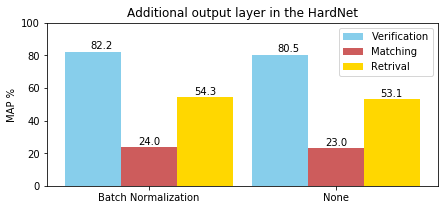

In [0]:
veri = (82.2, 80.5)
ret = (24.0, 23.0)
match = (54.3, 53.1)

ind = np.arange(len(veri))  # the x locations for the groups
width = 0.3  # the width of the bars

fig, ax = plt.subplots(figsize = (7, 3))

rects1 = ax.bar(ind - width, veri, width,
                color='SkyBlue', label='Verification')
rects2 = ax.bar(ind, ret, width,
                color='IndianRed', label='Matching')
rects3 = ax.bar(ind + width, match, width,
                color='Gold', label='Retrival')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('MAP %')
ax.set_title('Additional output layer in the HardNet')
ax.set_xticks(ind)
ax.set_xticklabels(('Batch Normalization', 'None', 'BN Trainable'))
ax.set_yticks([0, 20, 40, 60, 80, 100])
ax.legend()


def autolabel(rects, xpos='center'):
    """
    Attach a text label above each bar in *rects*, displaying its height.

    *xpos* indicates which side to place the text w.r.t. the center of
    the bar. It can be one of the following {'center', 'right', 'left'}.
    """

    xpos = xpos.lower()  # normalize the case of the parameter
    ha = {'center': 'center', 'right': 'left', 'left': 'right'}
    offset = {'center': 0.5, 'right': 0.3, 'left': 0.85}  # x_txt = x + w*off

    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()*offset[xpos], 1.01*height,
                '{}'.format(height), ha=ha[xpos], va='bottom')


autolabel(rects1, "left")
autolabel(rects2, "center")
autolabel(rects3, "right")

plt.show()

Here we are experimenting with training data for the descriptor while the final metrics are still done on the original data.

In [0]:
hPatchesClean = HPatches(train_fnames=train_fnames, test_fnames=test_fnames, denoise_model=denoise_model, use_clean=True)
training_generator_clean = DataGeneratorDesc(*hPatchesClean.read_image_file(hpatches_dir, train=1), num_triplets=100000)
val_generator_clean = DataGeneratorDesc(*hPatchesClean.read_image_file(hpatches_dir, train=0), num_triplets=10000)

Using clean patches
100%|██████████| 116/116 [00:35<00:00,  2.51it/s]


100%|██████████| 100000/100000 [00:01<00:00, 89595.14it/s]


Using clean patches
100%|██████████| 116/116 [00:21<00:00,  5.43it/s]


100%|██████████| 10000/10000 [00:00<00:00, 61566.50it/s]


Training and evaluating a model on entirely clean data.

In [0]:
def get_descriptor_model(shape):
  
  init_weights = keras.initializers.he_normal()
  
  descriptor_model = Sequential()
  
  descriptor_model.add(Conv2D(32, 3, padding='same', activation = 'relu', input_shape = shape , kernel_initializer=init_weights))
  descriptor_model.add(BatchNormalization(axis = -1, gamma_initializer = 'ones', beta_initializer = 'zeros', trainable = True))
  descriptor_model.add(Activation('relu'))

  descriptor_model.add(Conv2D(32, 3, padding='same', activation = 'relu', kernel_initializer=init_weights))
  descriptor_model.add(BatchNormalization(axis = -1, gamma_initializer = 'ones', beta_initializer = 'zeros', trainable = True))
  descriptor_model.add(Activation('relu'))

  descriptor_model.add(Conv2D(64, 3, padding='same', activation = 'relu', strides=2, kernel_initializer=init_weights))
  descriptor_model.add(BatchNormalization(axis = -1, gamma_initializer = 'ones', beta_initializer = 'zeros', trainable = True))
  descriptor_model.add(Activation('relu'))

  descriptor_model.add(Conv2D(64, 3, padding='same', activation = 'relu', kernel_initializer=init_weights))
  descriptor_model.add(BatchNormalization(axis = -1, gamma_initializer = 'ones', beta_initializer = 'zeros', trainable = True))
  descriptor_model.add(Activation('relu'))

  descriptor_model.add(Conv2D(128, 3, padding='same', activation = 'relu', strides=2, kernel_initializer=init_weights))
  descriptor_model.add(BatchNormalization(axis = -1, gamma_initializer = 'ones', beta_initializer = 'zeros', trainable = True))
  descriptor_model.add(Activation('relu'))

  descriptor_model.add(Conv2D(128, 3, padding='same', activation = 'relu', kernel_initializer=init_weights))
  descriptor_model.add(BatchNormalization(axis = -1, gamma_initializer = 'ones', beta_initializer = 'zeros', trainable = True))
  descriptor_model.add(Activation('relu'))
  descriptor_model.add(Dropout(0.3))
  descriptor_model.add(Conv2D(128, 8, padding='valid', kernel_initializer=init_weights))
                    
  descriptor_model.add(BatchNormalization(axis = -1, gamma_initializer = 'ones', beta_initializer = 'zeros', trainable = True))  
    
  descriptor_model.add(Reshape((128,)))

  
  return descriptor_model

def triplet_loss(x):

  output_dim = 128
  a, p, n = x
  _alpha = 1.0
  positive_distance = K.mean(K.square(a - p), axis = -1)
  negative_distance = K.mean(K.square(a - n), axis = -1)
  
  return K.expand_dims(K.maximum(0.0, positive_distance - negative_distance + _alpha), axis = 1)

In [0]:
shape = (32, 32, 1)
xa = Input(shape=shape, name='a')
xp = Input(shape=shape, name='p')
xn = Input(shape=shape, name='n')
descriptor_model = get_descriptor_model(shape)
ea = descriptor_model(xa)
ep = descriptor_model(xp)
en = descriptor_model(xn)

loss = Lambda(triplet_loss)([ea, ep, en])

descriptor_model_trip = Model(inputs=[xa, xp, xn], outputs=loss)

sgd = keras.optimizers.SGD(lr=0.1)
descriptor_model_trip.compile(loss='mean_absolute_error', optimizer=sgd)

In [0]:
descriptor_history_baseline_trip = descriptor_model_trip.fit_generator(generator=training_generator_clean, epochs=25, verbose=1, validation_data=val_generator)

generate_desc_csv(descriptor_model, seqs_test, denoise_model = denoise_model, use_clean = False)

!python ./hpatches-benchmark/hpatches_eval.py --descr-name=custom --descr-dir=out/ --task=verification --delimiter=";"
!python ./hpatches-benchmark/hpatches_results.py --descr=custom --results-dir=./hpatches-benchmark/results/ --task=verification

!python ./hpatches-benchmark/hpatches_eval.py --descr-name=custom --descr-dir=out/ --task=matching --delimiter=";"
!python ./hpatches-benchmark/hpatches_results.py --descr=custom --results-dir=./hpatches-benchmark/results/ --task=matching

!python ./hpatches-benchmark/hpatches_eval.py --descr-name=custom --descr-dir=out/ --task=retrieval --delimiter=";"
!python ./hpatches-benchmark/hpatches_results.py --descr=custom --results-dir=./hpatches-benchmark/results/ --task=retrieval

Epoch 1/25
1998/2000 [============================>.] - ETA: 0s - loss: 0.2657

 65%|██████▌   | 65450/100000 [00:02<00:01, 32506.21it/s]

2000/2000 [==============================] - 54s 27ms/step - loss: 0.2658 - val_loss: 0.2528


 71%|███████   | 70562/100000 [00:02<00:00, 36491.87it/s]

Epoch 2/25


100%|██████████| 100000/100000 [00:03<00:00, 26761.65it/s]A


1999/2000 [============================>.] - ETA: 0s - loss: 0.1749

 21%|██        | 21127/100000 [00:00<00:02, 30512.57it/s]

2000/2000 [==============================] - 48s 24ms/step - loss: 0.1749 - val_loss: 0.2211


 29%|██▉       | 28862/100000 [00:00<00:02, 27065.17it/s]

Epoch 3/25


100%|██████████| 100000/100000 [00:04<00:00, 24738.55it/s]


1998/2000 [============================>.] - ETA: 0s - loss: 0.1432

 21%|██        | 21112/100000 [00:00<00:02, 30745.32it/s]

2000/2000 [==============================] - 50s 25ms/step - loss: 0.1432 - val_loss: 0.2052


 28%|██▊       | 28240/100000 [00:00<00:02, 26654.20it/s]

Epoch 4/25


100%|██████████| 100000/100000 [00:02<00:00, 35255.91it/s]A


1998/2000 [============================>.] - ETA: 0s - loss: 0.1268

 24%|██▎       | 23649/100000 [00:00<00:02, 30518.70it/s]

2000/2000 [==============================] - 49s 24ms/step - loss: 0.1267 - val_loss: 0.1952


 27%|██▋       | 26609/100000 [00:00<00:02, 29468.36it/s]

Epoch 5/25


100%|██████████| 100000/100000 [00:02<00:00, 33468.30it/s]A


1997/2000 [============================>.] - ETA: 0s - loss: 0.1144

 21%|██        | 21036/100000 [00:00<00:02, 29059.01it/s]

2000/2000 [==============================] - 49s 24ms/step - loss: 0.1145 - val_loss: 0.2104


 29%|██▉       | 29296/100000 [00:00<00:02, 28287.80it/s]

Epoch 6/25


100%|██████████| 100000/100000 [00:02<00:00, 33371.73it/s]A


1998/2000 [============================>.] - ETA: 0s - loss: 0.1101

 21%|██        | 20846/100000 [00:00<00:02, 29537.46it/s]

2000/2000 [==============================] - 49s 24ms/step - loss: 0.1101 - val_loss: 0.1912


 29%|██▉       | 29041/100000 [00:00<00:02, 27125.77it/s]

Epoch 7/25


100%|██████████| 100000/100000 [00:03<00:00, 25089.73it/s]A


1997/2000 [============================>.] - ETA: 0s - loss: 0.1021

 20%|██        | 20264/100000 [00:00<00:02, 29658.98it/s]

2000/2000 [==============================] - 50s 25ms/step - loss: 0.1021 - val_loss: 0.1610


 28%|██▊       | 27669/100000 [00:00<00:02, 29527.57it/s]

Epoch 8/25


100%|██████████| 100000/100000 [00:03<00:00, 31589.73it/s]A


1998/2000 [============================>.] - ETA: 0s - loss: 0.0988

 25%|██▍       | 24968/100000 [00:00<00:02, 31426.89it/s]

2000/2000 [==============================] - 49s 24ms/step - loss: 0.0989 - val_loss: 0.1652


 28%|██▊       | 28167/100000 [00:00<00:02, 30881.34it/s]

Epoch 9/25


100%|██████████| 100000/100000 [00:02<00:00, 33510.02it/s]A


1998/2000 [============================>.] - ETA: 0s - loss: 0.0906

 17%|█▋        | 17416/100000 [00:00<00:02, 29156.86it/s]

2000/2000 [==============================] - 49s 24ms/step - loss: 0.0906 - val_loss: 0.1671


 25%|██▌       | 25309/100000 [00:00<00:02, 25774.82it/s]

Epoch 10/25


100%|██████████| 100000/100000 [00:02<00:00, 35109.11it/s]A


1998/2000 [============================>.] - ETA: 0s - loss: 0.0857

 27%|██▋       | 26617/100000 [00:01<00:04, 15784.65it/s]

2000/2000 [==============================] - 50s 25ms/step - loss: 0.0857 - val_loss: 0.1606


 30%|███       | 30223/100000 [00:01<00:03, 18800.15it/s]

Epoch 11/25


100%|██████████| 100000/100000 [00:03<00:00, 25332.65it/s]A


1999/2000 [============================>.] - ETA: 0s - loss: 0.0826

 22%|██▏       | 21734/100000 [00:00<00:02, 31639.24it/s]

2000/2000 [==============================] - 49s 24ms/step - loss: 0.0826 - val_loss: 0.1701


 29%|██▉       | 29171/100000 [00:00<00:02, 30481.78it/s]

Epoch 12/25


100%|██████████| 100000/100000 [00:03<00:00, 32140.74it/s]A


1997/2000 [============================>.] - ETA: 0s - loss: 0.0815

 22%|██▏       | 21989/100000 [00:00<00:02, 32335.22it/s]

2000/2000 [==============================] - 49s 25ms/step - loss: 0.0815 - val_loss: 0.1738


 26%|██▋       | 26319/100000 [00:00<00:02, 33213.89it/s]

Epoch 13/25


100%|██████████| 100000/100000 [00:02<00:00, 34769.82it/s]A


1997/2000 [============================>.] - ETA: 0s - loss: 0.0793

 25%|██▍       | 24866/100000 [00:00<00:02, 32057.23it/s]

2000/2000 [==============================] - 49s 24ms/step - loss: 0.0794 - val_loss: 0.1422


 28%|██▊       | 28008/100000 [00:00<00:02, 31269.18it/s]

Epoch 14/25


100%|██████████| 100000/100000 [00:02<00:00, 34363.64it/s]A


1998/2000 [============================>.] - ETA: 0s - loss: 0.0781

 24%|██▍       | 24255/100000 [00:00<00:02, 29689.27it/s]

2000/2000 [==============================] - 50s 25ms/step - loss: 0.0781 - val_loss: 0.1678


 32%|███▏      | 31887/100000 [00:01<00:02, 29421.82it/s]

Epoch 15/25


100%|██████████| 100000/100000 [00:03<00:00, 31279.09it/s]A


1999/2000 [============================>.] - ETA: 0s - loss: 0.0756

 26%|██▌       | 25848/100000 [00:00<00:02, 33535.14it/s]

2000/2000 [==============================] - 49s 24ms/step - loss: 0.0757 - val_loss: 0.1355


 29%|██▉       | 29094/100000 [00:00<00:02, 32692.61it/s]

Epoch 16/25


100%|██████████| 100000/100000 [00:02<00:00, 34703.16it/s]A


1999/2000 [============================>.] - ETA: 0s - loss: 0.0734

 25%|██▌       | 25462/100000 [00:00<00:02, 32735.16it/s]

2000/2000 [==============================] - 49s 24ms/step - loss: 0.0733 - val_loss: 0.1647


 29%|██▊       | 28710/100000 [00:00<00:02, 32451.05it/s]

Epoch 17/25


100%|██████████| 100000/100000 [00:03<00:00, 33078.24it/s]A


1998/2000 [============================>.] - ETA: 0s - loss: 0.0715

 25%|██▍       | 24750/100000 [00:00<00:02, 32134.96it/s]

2000/2000 [==============================] - 49s 24ms/step - loss: 0.0715 - val_loss: 0.1433


 28%|██▊       | 27994/100000 [00:00<00:02, 32220.50it/s]

Epoch 18/25


100%|██████████| 100000/100000 [00:04<00:00, 24389.74it/s]A


1999/2000 [============================>.] - ETA: 0s - loss: 0.0714

 26%|██▌       | 25800/100000 [00:00<00:02, 32986.76it/s]

2000/2000 [==============================] - 50s 25ms/step - loss: 0.0714 - val_loss: 0.1332


 29%|██▉       | 28965/100000 [00:00<00:02, 31620.26it/s]

Epoch 19/25


100%|██████████| 100000/100000 [00:02<00:00, 35738.87it/s]A


1999/2000 [============================>.] - ETA: 0s - loss: 0.0704

 26%|██▌       | 25666/100000 [00:00<00:02, 32894.73it/s]

2000/2000 [==============================] - 49s 24ms/step - loss: 0.0704 - val_loss: 0.1652


 31%|███       | 30647/100000 [00:00<00:02, 33931.65it/s]

Epoch 20/25


100%|██████████| 100000/100000 [00:02<00:00, 34839.96it/s]A


1998/2000 [============================>.] - ETA: 0s - loss: 0.0665

 22%|██▏       | 21832/100000 [00:00<00:02, 30805.60it/s]

2000/2000 [==============================] - 49s 24ms/step - loss: 0.0665 - val_loss: 0.1754


 26%|██▋       | 26461/100000 [00:00<00:02, 32204.66it/s]

Epoch 21/25


100%|██████████| 100000/100000 [00:02<00:00, 34639.63it/s]A


1998/2000 [============================>.] - ETA: 0s - loss: 0.0651

 21%|██▏       | 21375/100000 [00:00<00:02, 30002.95it/s]

2000/2000 [==============================] - 49s 24ms/step - loss: 0.0652 - val_loss: 0.1485


 26%|██▌       | 25893/100000 [00:00<00:02, 33364.09it/s]

Epoch 22/25


100%|██████████| 100000/100000 [00:04<00:00, 23994.10it/s]A


1999/2000 [============================>.] - ETA: 0s - loss: 0.0660

 24%|██▍       | 24497/100000 [00:00<00:02, 31659.39it/s]

2000/2000 [==============================] - 50s 25ms/step - loss: 0.0660 - val_loss: 0.1302


 32%|███▏      | 31584/100000 [00:01<00:02, 25697.68it/s]

Epoch 23/25


100%|██████████| 100000/100000 [00:03<00:00, 32675.55it/s]A


1997/2000 [============================>.] - ETA: 0s - loss: 0.0632

 26%|██▌       | 25527/100000 [00:00<00:02, 33841.15it/s]

2000/2000 [==============================] - 49s 24ms/step - loss: 0.0631 - val_loss: 0.1421


 29%|██▉       | 29042/100000 [00:00<00:02, 33215.70it/s]

Epoch 24/25


100%|██████████| 100000/100000 [00:02<00:00, 34923.62it/s]A


1999/2000 [============================>.] - ETA: 0s - loss: 0.0619

 23%|██▎       | 22642/100000 [00:00<00:02, 33746.32it/s]

2000/2000 [==============================] - 49s 24ms/step - loss: 0.0619 - val_loss: 0.1316


 26%|██▌       | 26039/100000 [00:00<00:02, 32732.74it/s]

Epoch 25/25


100%|██████████| 100000/100000 [00:03<00:00, 32520.03it/s]A


1998/2000 [============================>.] - ETA: 0s - loss: 0.0618

 27%|██▋       | 27276/100000 [00:01<00:04, 17284.50it/s]

2000/2000 [==============================] - 50s 25ms/step - loss: 0.0619 - val_loss: 0.1527


100%|██████████| 40/40 [04:39<00:00,  5.66s/it]



>> Running HPatch evaluation for custom
>> Please wait, loading the descriptor files...
>> Descriptor files loaded.
>> Evaluating verification task
Processing verification task 3/3 : 100%|██████████| 1000000/1000000 [01:14<00:00, 13453.32it/s]
>> Verification task finished in 231 secs  
Verification task results:
Mean Average Precision is 0.762450



>> Running HPatch evaluation for custom
>> Please wait, loading the descriptor files...
>> Descriptor files loaded.
>> Evaluating matching task
100%|██████████| 40/40 [01:50<00:00,  3.75s/it]
>> Matching task finished in 111 secs  
Matching task results:
Mean Average Precision is 0.153003





>> Running HPatch evaluation for custom
>> Please wait, loading the descriptor files...
>> Descriptor files loaded.
>> Evaluating retrieval task
>> Please wait, computing distance matrix...
>> Distance matrix done.
Processing retrieval task: 100%|██████████| 10000/10000 [03:33<00:00, 46.87it/s]
>> Retrieval task finished in 229 secs  
Retrieval task

Training and evaluating a network on clean and denoised data alteranting the training.

In [0]:
shape = (32, 32, 1)
xa = Input(shape=shape, name='a')
xp = Input(shape=shape, name='p')
xn = Input(shape=shape, name='n')
descriptor_model = get_descriptor_model(shape)
ea = descriptor_model(xa)
ep = descriptor_model(xp)
en = descriptor_model(xn)

loss = Lambda(triplet_loss)([ea, ep, en])

descriptor_model_trip = Model(inputs=[xa, xp, xn], outputs=loss)

sgd = keras.optimizers.SGD(lr=0.1)
descriptor_model_trip.compile(loss='mean_absolute_error', optimizer=sgd)

In [0]:
descriptor_history_baseline_trip = descriptor_model_trip.fit_generator(generator=training_generator_clean, epochs=1, verbose=1, validation_data=val_generator)
descriptor_history_baseline_trip = descriptor_model_trip.fit_generator(generator=training_generator, epochs=1, verbose=1, validation_data=val_generator)
descriptor_history_baseline_trip = descriptor_model_trip.fit_generator(generator=training_generator_clean, epochs=1, verbose=1, validation_data=val_generator)
descriptor_history_baseline_trip = descriptor_model_trip.fit_generator(generator=training_generator, epochs=1, verbose=1, validation_data=val_generator)
descriptor_history_baseline_trip = descriptor_model_trip.fit_generator(generator=training_generator_clean, epochs=1, verbose=1, validation_data=val_generator)
descriptor_history_baseline_trip = descriptor_model_trip.fit_generator(generator=training_generator, epochs=1, verbose=1, validation_data=val_generator)
descriptor_history_baseline_trip = descriptor_model_trip.fit_generator(generator=training_generator_clean, epochs=1, verbose=1, validation_data=val_generator)
descriptor_history_baseline_trip = descriptor_model_trip.fit_generator(generator=training_generator, epochs=1, verbose=1, validation_data=val_generator)
descriptor_history_baseline_trip = descriptor_model_trip.fit_generator(generator=training_generator_clean, epochs=1, verbose=1, validation_data=val_generator)
descriptor_history_baseline_trip = descriptor_model_trip.fit_generator(generator=training_generator, epochs=1, verbose=1, validation_data=val_generator)
descriptor_history_baseline_trip = descriptor_model_trip.fit_generator(generator=training_generator_clean, epochs=1, verbose=1, validation_data=val_generator)
descriptor_history_baseline_trip = descriptor_model_trip.fit_generator(generator=training_generator, epochs=1, verbose=1, validation_data=val_generator)
descriptor_history_baseline_trip = descriptor_model_trip.fit_generator(generator=training_generator_clean, epochs=1, verbose=1, validation_data=val_generator)
descriptor_history_baseline_trip = descriptor_model_trip.fit_generator(generator=training_generator, epochs=1, verbose=1, validation_data=val_generator)
descriptor_history_baseline_trip = descriptor_model_trip.fit_generator(generator=training_generator_clean, epochs=1, verbose=1, validation_data=val_generator)
descriptor_history_baseline_trip = descriptor_model_trip.fit_generator(generator=training_generator, epochs=1, verbose=1, validation_data=val_generator)
descriptor_history_baseline_trip = descriptor_model_trip.fit_generator(generator=training_generator_clean, epochs=1, verbose=1, validation_data=val_generator)
descriptor_history_baseline_trip = descriptor_model_trip.fit_generator(generator=training_generator, epochs=1, verbose=1, validation_data=val_generator)
descriptor_history_baseline_trip = descriptor_model_trip.fit_generator(generator=training_generator_clean, epochs=1, verbose=1, validation_data=val_generator)
descriptor_history_baseline_trip = descriptor_model_trip.fit_generator(generator=training_generator, epochs=1, verbose=1, validation_data=val_generator)
descriptor_history_baseline_trip = descriptor_model_trip.fit_generator(generator=training_generator_clean, epochs=1, verbose=1, validation_data=val_generator)
descriptor_history_baseline_trip = descriptor_model_trip.fit_generator(generator=training_generator, epochs=1, verbose=1, validation_data=val_generator)
descriptor_history_baseline_trip = descriptor_model_trip.fit_generator(generator=training_generator_clean, epochs=1, verbose=1, validation_data=val_generator)
descriptor_history_baseline_trip = descriptor_model_trip.fit_generator(generator=training_generator, epochs=1, verbose=1, validation_data=val_generator)
descriptor_history_baseline_trip = descriptor_model_trip.fit_generator(generator=training_generator_clean, epochs=1, verbose=1, validation_data=val_generator)

generate_desc_csv(descriptor_model, seqs_test, denoise_model = denoise_model, use_clean = False)

!python ./hpatches-benchmark/hpatches_eval.py --descr-name=custom --descr-dir=out/ --task=verification --delimiter=";"
!python ./hpatches-benchmark/hpatches_results.py --descr=custom --results-dir=./hpatches-benchmark/results/ --task=verification

!python ./hpatches-benchmark/hpatches_eval.py --descr-name=custom --descr-dir=out/ --task=matching --delimiter=";"
!python ./hpatches-benchmark/hpatches_results.py --descr=custom --results-dir=./hpatches-benchmark/results/ --task=matching

!python ./hpatches-benchmark/hpatches_eval.py --descr-name=custom --descr-dir=out/ --task=retrieval --delimiter=";"
!python ./hpatches-benchmark/hpatches_results.py --descr=custom --results-dir=./hpatches-benchmark/results/ --task=retrieval

Epoch 1/1
1997/2000 [============================>.] - ETA: 0s - loss: 0.2644

 85%|████████▍ | 84738/100000 [00:02<00:00, 32947.83it/s]

2000/2000 [==============================] - 56s 28ms/step - loss: 0.2642 - val_loss: 0.3574


100%|██████████| 10000/10000 [00:00<00:00, 61356.11it/s]


Epoch 1/1
1999/2000 [============================>.] - ETA: 0s - loss: 0.1793

 29%|██▉       | 29262/100000 [00:00<00:02, 33894.79it/s]

2000/2000 [==============================] - 47s 24ms/step - loss: 0.1792 - val_loss: 0.3021


100%|██████████| 100000/100000 [00:03<00:00, 33005.02it/s]A


Epoch 1/1
1998/2000 [============================>.] - ETA: 0s - loss: 0.1391

 28%|██▊       | 28281/100000 [00:00<00:02, 32288.75it/s]

2000/2000 [==============================] - 47s 23ms/step - loss: 0.1391 - val_loss: 0.1953


100%|██████████| 100000/100000 [00:04<00:00, 22976.66it/s]A


Epoch 1/1
1998/2000 [============================>.] - ETA: 0s - loss: 0.1417

 29%|██▊       | 28731/100000 [00:00<00:02, 32594.72it/s]

2000/2000 [==============================] - 47s 23ms/step - loss: 0.1416 - val_loss: 0.2311


100%|██████████| 100000/100000 [00:03<00:00, 33247.39it/s]A


Epoch 1/1
1997/2000 [============================>.] - ETA: 0s - loss: 0.1152

 25%|██▌       | 25202/100000 [00:00<00:02, 32046.08it/s]

2000/2000 [==============================] - 47s 24ms/step - loss: 0.1150 - val_loss: 0.1754


100%|██████████| 100000/100000 [00:03<00:00, 30163.17it/s]A


Epoch 1/1
1999/2000 [============================>.] - ETA: 0s - loss: 0.1254

 29%|██▉       | 29360/100000 [00:00<00:02, 34474.66it/s]

2000/2000 [==============================] - 47s 24ms/step - loss: 0.1254 - val_loss: 0.1889


100%|██████████| 100000/100000 [00:02<00:00, 33384.76it/s]A


Epoch 1/1
1997/2000 [============================>.] - ETA: 0s - loss: 0.0984

 29%|██▉       | 29486/100000 [00:00<00:02, 34280.67it/s]

2000/2000 [==============================] - 47s 23ms/step - loss: 0.0984 - val_loss: 0.1732


100%|██████████| 100000/100000 [00:03<00:00, 32744.94it/s]A


Epoch 1/1
1999/2000 [============================>.] - ETA: 0s - loss: 0.1150

 31%|███       | 30628/100000 [00:00<00:01, 35216.43it/s]

2000/2000 [==============================] - 48s 24ms/step - loss: 0.1151 - val_loss: 0.1473


100%|██████████| 100000/100000 [00:03<00:00, 32525.13it/s]A


Epoch 1/1
1999/2000 [============================>.] - ETA: 0s - loss: 0.0892

 29%|██▊       | 28648/100000 [00:00<00:02, 32805.04it/s]

2000/2000 [==============================] - 47s 24ms/step - loss: 0.0892 - val_loss: 0.1885


100%|██████████| 100000/100000 [00:02<00:00, 34441.41it/s]A


Epoch 1/1
1999/2000 [============================>.] - ETA: 0s - loss: 0.1080

 30%|██▉       | 29514/100000 [00:00<00:02, 33043.06it/s]

2000/2000 [==============================] - 47s 23ms/step - loss: 0.1080 - val_loss: 0.1424


100%|██████████| 100000/100000 [00:02<00:00, 33594.62it/s]A


Epoch 1/1
1997/2000 [============================>.] - ETA: 0s - loss: 0.0822

 29%|██▉       | 28752/100000 [00:00<00:02, 31954.66it/s]

2000/2000 [==============================] - 47s 23ms/step - loss: 0.0824 - val_loss: 0.1428


100%|██████████| 100000/100000 [00:03<00:00, 32456.60it/s]A


Epoch 1/1
1999/2000 [============================>.] - ETA: 0s - loss: 0.1035

 28%|██▊       | 28410/100000 [00:02<00:05, 12323.47it/s]

2000/2000 [==============================] - 48s 24ms/step - loss: 0.1034 - val_loss: 0.1254


100%|██████████| 100000/100000 [00:04<00:00, 21570.85it/s]A


Epoch 1/1
1999/2000 [============================>.] - ETA: 0s - loss: 0.0791

 29%|██▉       | 29196/100000 [00:00<00:02, 34207.71it/s]

2000/2000 [==============================] - 47s 24ms/step - loss: 0.0791 - val_loss: 0.1531


100%|██████████| 100000/100000 [00:03<00:00, 32533.19it/s]A


Epoch 1/1
1998/2000 [============================>.] - ETA: 0s - loss: 0.1003

 29%|██▊       | 28628/100000 [00:00<00:02, 31949.39it/s]

2000/2000 [==============================] - 47s 23ms/step - loss: 0.1003 - val_loss: 0.1459


100%|██████████| 100000/100000 [00:02<00:00, 33768.11it/s]A


Epoch 1/1
1998/2000 [============================>.] - ETA: 0s - loss: 0.0747

 28%|██▊       | 28471/100000 [00:00<00:02, 32661.04it/s]

2000/2000 [==============================] - 47s 23ms/step - loss: 0.0747 - val_loss: 0.1421


100%|██████████| 100000/100000 [00:02<00:00, 33408.72it/s]A


Epoch 1/1
1997/2000 [============================>.] - ETA: 0s - loss: 0.0980

 30%|██▉       | 29678/100000 [00:00<00:02, 33830.05it/s]

2000/2000 [==============================] - 47s 23ms/step - loss: 0.0980 - val_loss: 0.1249


100%|██████████| 100000/100000 [00:04<00:00, 24002.45it/s]A


Epoch 1/1
1998/2000 [============================>.] - ETA: 0s - loss: 0.0703

 29%|██▉       | 29423/100000 [00:00<00:02, 32603.45it/s]

2000/2000 [==============================] - 47s 24ms/step - loss: 0.0703 - val_loss: 0.1688


100%|██████████| 100000/100000 [00:02<00:00, 33366.28it/s]A


Epoch 1/1
1997/2000 [============================>.] - ETA: 0s - loss: 0.0930

 29%|██▉       | 29012/100000 [00:00<00:02, 34095.54it/s]

2000/2000 [==============================] - 47s 23ms/step - loss: 0.0930 - val_loss: 0.1185


100%|██████████| 100000/100000 [00:02<00:00, 34156.28it/s]A


Epoch 1/1
1999/2000 [============================>.] - ETA: 0s - loss: 0.0675

 29%|██▉       | 29127/100000 [00:00<00:02, 34910.71it/s]

2000/2000 [==============================] - 47s 23ms/step - loss: 0.0675 - val_loss: 0.1318


100%|██████████| 100000/100000 [00:03<00:00, 33158.57it/s]A


Epoch 1/1
1997/2000 [============================>.] - ETA: 0s - loss: 0.0913

 28%|██▊       | 28440/100000 [00:00<00:02, 31836.13it/s]

2000/2000 [==============================] - 47s 24ms/step - loss: 0.0913 - val_loss: 0.1414


100%|██████████| 100000/100000 [00:04<00:00, 23715.71it/s]A


Epoch 1/1
1998/2000 [============================>.] - ETA: 0s - loss: 0.0652

 28%|██▊       | 28380/100000 [00:00<00:02, 30877.56it/s]

2000/2000 [==============================] - 47s 23ms/step - loss: 0.0651 - val_loss: 0.1263


100%|██████████| 100000/100000 [00:03<00:00, 32005.59it/s]A


Epoch 1/1
1998/2000 [============================>.] - ETA: 0s - loss: 0.0900

 25%|██▍       | 24992/100000 [00:00<00:02, 31456.03it/s]

2000/2000 [==============================] - 47s 23ms/step - loss: 0.0900 - val_loss: 0.1152


100%|██████████| 100000/100000 [00:02<00:00, 33594.23it/s]A


Epoch 1/1
1997/2000 [============================>.] - ETA: 0s - loss: 0.0635

 24%|██▍       | 24197/100000 [00:00<00:02, 31699.57it/s]

2000/2000 [==============================] - 47s 23ms/step - loss: 0.0634 - val_loss: 0.1352


100%|██████████| 100000/100000 [00:03<00:00, 32933.93it/s]A


Epoch 1/1
1997/2000 [============================>.] - ETA: 0s - loss: 0.0875

 29%|██▉       | 29284/100000 [00:00<00:02, 34162.51it/s]

2000/2000 [==============================] - 47s 24ms/step - loss: 0.0876 - val_loss: 0.1399


100%|██████████| 100000/100000 [00:02<00:00, 34014.81it/s]A


Epoch 1/1
1997/2000 [============================>.] - ETA: 0s - loss: 0.0616

 31%|███       | 30637/100000 [00:00<00:02, 34392.23it/s]

2000/2000 [==============================] - 48s 24ms/step - loss: 0.0615 - val_loss: 0.1297


100%|██████████| 40/40 [04:56<00:00,  5.99s/it]



>> Running HPatch evaluation for custom
>> Please wait, loading the descriptor files...
>> Descriptor files loaded.
>> Evaluating verification task
Processing verification task 3/3 : 100%|██████████| 1000000/1000000 [01:15<00:00, 13230.10it/s]
>> Verification task finished in 231 secs  
Verification task results:
Mean Average Precision is 0.814124



>> Running HPatch evaluation for custom
>> Please wait, loading the descriptor files...
>> Descriptor files loaded.
>> Evaluating matching task
100%|██████████| 40/40 [01:49<00:00,  3.68s/it]
>> Matching task finished in 109 secs  
Matching task results:
Mean Average Precision is 0.204938





>> Running HPatch evaluation for custom
>> Please wait, loading the descriptor files...
>> Descriptor files loaded.
>> Evaluating retrieval task
>> Please wait, computing distance matrix...
>> Distance matrix done.
Processing retrieval task: 100%|██████████| 10000/10000 [03:34<00:00, 46.72it/s]
>> Retrieval task finished in 230 secs  
Retrieval task

Visualising the results.

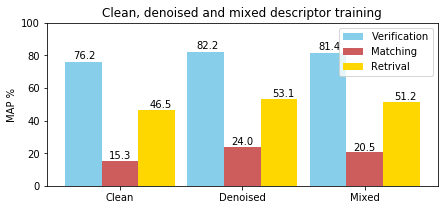

In [0]:
veri = (76.2, 82.2, 81.4)
ret = (15.3, 24.0, 20.5)
match = (46.5, 53.1, 51.2)

ind = np.arange(len(veri))  # the x locations for the groups
width = 0.3  # the width of the bars

fig, ax = plt.subplots(figsize = (7, 3))

rects1 = ax.bar(ind - width, veri, width,
                color='SkyBlue', label='Verification')
rects2 = ax.bar(ind, ret, width,
                color='IndianRed', label='Matching')
rects3 = ax.bar(ind + width, match, width,
                color='Gold', label='Retrival')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('MAP %')
ax.set_title('Clean, denoised and mixed descriptor training')
ax.set_xticks(ind)
ax.set_xticklabels(('Clean', 'Denoised', 'Mixed'))
ax.set_yticks([0, 20, 40, 60, 80, 100])
ax.legend()


def autolabel(rects, xpos='center'):
    """
    Attach a text label above each bar in *rects*, displaying its height.

    *xpos* indicates which side to place the text w.r.t. the center of
    the bar. It can be one of the following {'center', 'right', 'left'}.
    """

    xpos = xpos.lower()  # normalize the case of the parameter
    ha = {'center': 'center', 'right': 'left', 'left': 'right'}
    offset = {'center': 0.5, 'right': 0.3, 'left': 0.85}  # x_txt = x + w*off

    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()*offset[xpos], 1.01*height,
                '{}'.format(height), ha=ha[xpos], va='bottom')


autolabel(rects1, "left")
autolabel(rects2, "center")
autolabel(rects3, "right")

plt.show()